# Collecting data from GooglePlay

This notebook is used to collect the dataset 'reviews.csv'. You are free to modify this code and customise the dataset according to your goals.

**Note:**

This code is designed to collect almost similar number of positive and negative reviews. However, it aims to show a way of data collection, may not be case of your analysis.

The function used for scraping app info and reviews is [google-play-scraper](https://github.com/JoMingyu/google-play-scraper).

## Setup

Let's install the required packages and setup the imports:

In [52]:
# First time running this code, you need to install package 'google_play_scraper' 
#!pip install --upgrade google_play_scraper

In [53]:
import json
import pandas as pd
from tqdm import tqdm

import pprint as pp

import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshmarkwell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now let's create a list of Apps we want to collect.

We will need 'the Google Play ID', which is the unique identifier of an Android application. 
It can be found by searching for the app and finding the Play store web page for the app.

In the example below, the Google Play ID is ``com.amazon.mShop.android.shopping``, which you can find directly from its url address:

https://play.google.com/store/apps/details?id=com.amazon.mShop.android.shopping

You are free to define your own list of Apps.

In [54]:
# List of Apps and their packages to be collected. Here I choose some Apps under the category 'productivity'
original_app_packages = [
    'com.amazon.mShop.android.shopping',
    'com.tesco.grocery.view',
    'com.homeretailgroup.argos.android',
    'com.morrisons.atm.mobile.android',
    'com.marksandspencer.app',
    'com.boots.flagship.android',
    'com.asos.app',
    'com.poqstudio.app.platform.boohoo'
]

##I have added ASOS and Boohoo


In [55]:
app_packages = ['com.asos.app',
    'com.poqstudio.app.platform.boohoo']

##I have added ASOS and Boohoo

## Scraping App Information

Let's scrape the info for each app:

In [56]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='uk') # from the UK markert
    del info['comments']
    app_infos.append(info)

100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Let's look at the corresponding JSON objects:

In [57]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [58]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "5.0",
  "androidVersionText": "5.0 and up",
  "appId": "com.asos.app",
  "containsAds": false,
  "contentRating": "PEGI 3",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Here\u2019s the situation: fresh pieces dropping daily, exclusive ranges you can't get anywhere else and new brands being added all the time \u2013 plus free delivery and returns. Wherever and whoever you are, exploring your style never felt so good.\r\n\r\nWith the ASOS app for Android, you can: \r\n\r\n- FIND & SAVE WHAT YOU WANT \r\nYou can still shop every piece you'll find on ASOS. Search by type, size, brand, price and color, or browse and buy our trend and occasion edits. Plus, your Saved Items and Shopping Bag sync between your devices, too \u2013 genius.\r\n\r\n- ENJOY SUPER-EASY CHECKOUT \r\nAdd a new credit card with our camera card scanner (#techy) for our quickest checkout ever. \r\n\r\n- GET HANDY SALE ALERTS \r\nOur push notificat

## Print Logos

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print all their logos. 

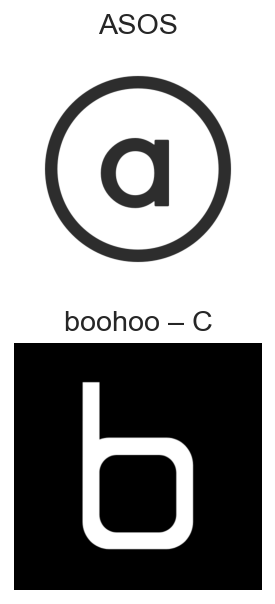

In [59]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [60]:
# App Data into Pandas DF and store it
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('./apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

See https://github.com/JoMingyu/google-play-scraper for configurations of function ``google_play_scraper.reviews``.

In [61]:
# This is an example of the function google_play_scraper.reviews
result, continuation_token = reviews(
    'com.fantome.penguinisle',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    count=1, # defaults to 100
    filter_score_with=5 # defaults to None(means all score)
)
result

[{'reviewId': 'gp:AOqpTOHF6WixGZzZ6zL5Q9XevDAUYs1RO3L_B_Z-fjB6jygnAkbOe_ZTJC6A6pVutS8DxXzHy2fo0c6nYutEFqc',
  'userName': 'Clash gaming',
  'userImage': 'https://play-lh.googleusercontent.com/a-/AOh14GilffkROJxDw-adi45JvOQplUwy1D82fv-U6fhk',
  'content': "Ok I can't lie this game is the best thing I have ever played, well phone games at least. There are no ads (unless you use it to get coins) and the game its self passes so much time. And not only that but it is so fun. You can decorate your island and expand it, and more. 10/10 complete recommend. Ps they didn't pay me I just love this game.",
  'score': 5,
  'thumbsUpCount': 14,
  'reviewCreatedVersion': '1.32.1',
  'at': datetime.datetime(2021, 4, 2, 2, 3, 31),
  'replyContent': None,
  'repliedAt': None}]

In [62]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='uk',
                sort=sort_order,
                count= 150 if score == 3 else 200,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)

100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [63]:
print_json(app_reviews[0])

{
  "appId": "com.asos.app",
  "at": "2021-04-03 20:58:06",
  "content": "App screenshots in playstore clearly says supports English however app uses country to determine language and not my phone settings",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "4.46.0",
  "reviewId": "gp:AOqpTOEse_aiLDQsRgCE_T-_iv8RBhk_TipuFDmYn7exDJjtbA6s9XzjQkwr1HOa8eRCR4R4iwCgIqOmEa-2ZQ",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/a-/AOh14GhC_vTCDQMrHlcc0_qjcsxX4kupAiJ8jll8xbvz9Q",
  "userName": "Kosh Sergani"
}



`repliedAt` and `replyContent` contain the developer response to the review.

So, how many app reviews did we get?



In [64]:
print("We were able to scrap: ", len(app_reviews), " reviews")

We were able to scrap:  1900  reviews


Let's save the reviews to a CSV file:

In [65]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('./reviews.csv', index=None, header=True)

In [66]:
#app_reviews_df.head()

In [67]:
#Creating a dictionary will all information from the asos and boohoo reviews
app_reviews_dict = {'asos': [review 
                            for review in app_reviews
                            if review['appId'] == 'com.asos.app'], 
                   'boohoo': [review 
                            for review in app_reviews
                            if review['appId'] == 'com.poqstudio.app.platform.boohoo']}

In [68]:
#pp.pprint(app_reviews_dict['asos'][0]['content'])

In [69]:
#### Before moving on, I want to expand all the contractios. This is because Doesn't will 
#never report the 'not' for example


In [70]:
#Imports
import re
import nltk
from nltk.probability import FreqDist


In [71]:
#This function fixes all common contractions
import re

def fix_contractions(dictonary, company):
    dictionary_copy = dictonary.copy()
    
    index = 0
    for review in dictionary_copy[company]:
        phrase = re.sub(r"won\'t", "will not", review['content'])  ##I sort of guessed and got this to work...
        phrase = re.sub(r"can\'t", "can not", phrase)

    # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        
        dictionary_copy[company][index]['content'] = phrase
        
        index += 1
    
    
    return dictionary_copy
    

In [72]:
#             app_reviews_dict_fixed is the normal dictionary but with the contractions expanded
app_reviews_dict_fixed = fix_contractions(app_reviews_dict, 'asos')
app_reviews_dict_fixed = fix_contractions(app_reviews_dict, 'boohoo')

In [73]:
##This function will create the desired ngram amount

from nltk.util import ngrams

def create_ngrams(content, gram_amount):
    new_content = content.copy()
    
#     numbers_1_to_100 = [str(integer) for integer in range(101)]
#     extra_punctuation_to_remove = ['.', '..','...','....','.....','......', ').', '.,',
#                                    "'m", "'s", "n't", "'ve", "'m", 'I', '!!!!']
#     individual_letters = list(string.ascii_lowercase)
    
#     remove_these = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + 
#                      numbers_1_to_100 +  extra_punctuation_to_remove + individual_letters)
    

    
    text = ""
    for review in content:
        text += review
        
    token = nltk.word_tokenize(text)
    
    
    
 
    
    ngram = list(ngrams(token, gram_amount))      
    
    
    
    return ngram

In [74]:
#Using this function to find a ngram amount for each score level. Calls the function above inside this funcion

def find_ngram(dictionary, company, gramsize):
    

    
    one_gram = []
    two_gram = []
    three_gram = []
    four_gram = []
    five_gram = []
    
    for review in dictionary[company]:
        if review['score'] == 1:
            #one_gram.append(create_ngrams(review['content'], gramsize))
            one_gram.append(review['content'].lower())
        elif review['score'] == 2:
            #two_gram.append(create_ngrams(review['content'], gramsize))
            two_gram.append(review['content'].lower())
        elif review['score'] == 3:
            #three_gram.append(create_ngrams(review['content'], gramsize))
            three_gram.append(review['content'].lower())
        elif review['score'] == 4:
            #four_gram.append(create_ngrams(review['content'], gramsize)) 
            four_gram.append(review['content'].lower())
        else:
            #five_gram.append(create_ngrams(review['content'], gramsize)) 
            five_gram.append(review['content'].lower())
    
    score_dict = {'one_score':one_gram, 'two_score':two_gram, 'three_score': three_gram, 'four_score': four_gram,
                 'five_score':five_gram}
    

    ngram_dict = {'one_score':create_ngrams(score_dict['one_score'], gramsize),
                  'two_score':create_ngrams(score_dict['two_score'], gramsize), 
                  'three_score': create_ngrams(score_dict['three_score'], gramsize), 
                  'four_score': create_ngrams(score_dict['four_score'], gramsize),
                 'five_score':create_ngrams(score_dict['five_score'], gramsize)}
    
            
            
    return ngram_dict

In [75]:
#these are dictionaries containing the desired ngram for each score level
#Call above function

asos_ngram_dict = find_ngram(app_reviews_dict_fixed,'asos', 4)
boohoo_ngram_dict = find_ngram(app_reviews_dict_fixed,'boohoo', 4)

asos_ngram_dict.keys(), boohoo_ngram_dict.keys()


(dict_keys(['one_score', 'two_score', 'three_score', 'four_score', 'five_score']),
 dict_keys(['one_score', 'two_score', 'three_score', 'four_score', 'five_score']))

In [76]:
#The charts printouts and graphs below show the 15 most common 4-grams

[(('!', '!', '!', '!'), 15), (('do', 'not', 'ship', 'to'), 3), (('.', 'customer', 'service', 'was'), 3), (('are', 'not', 'able', 'to'), 3), (('to', 'leave', 'the', 'house'), 3), (('!', '!', '!', 'i'), 3), (('do', 'not', 'want', 'to'), 3), (('this', 'app', '.', 'you'), 2), (('ship', 'to', 'my', 'country'), 2), (('do', 'not', 'waste', 'your'), 2), (('not', 'waste', 'your', 'time'), 2), (('delete', 'this', 'app', '.'), 2), (('a', 'month', 'of', 'back'), 2), (('when', 'it', 'comes', 'to'), 2), (('i', 'have', 'not', 'received'), 2)]


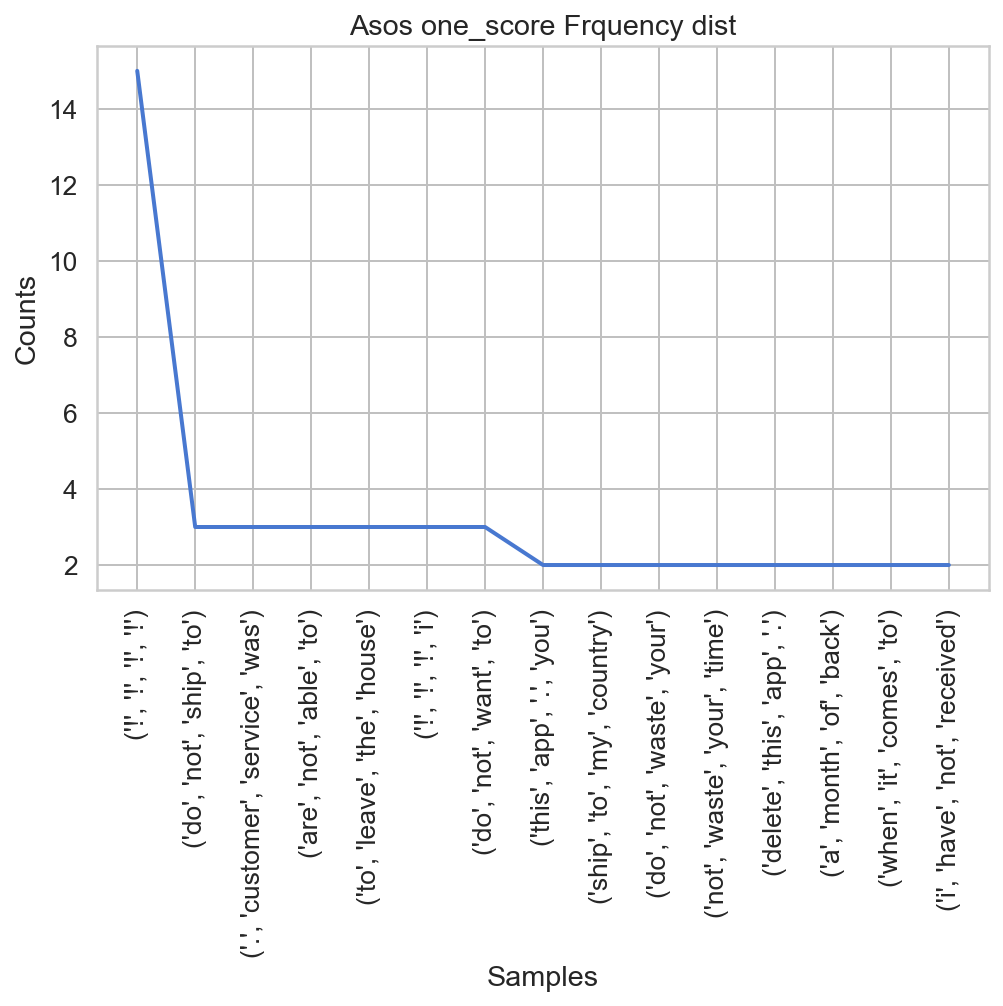

[(('can', 'not', 'be', 'delivered'), 3), (('that', 'i', 'can', 'not'), 3), (('!', '!', '!', '!'), 3), (('that', 'they', 'do', 'not'), 2), (('they', 'do', 'not', 'really'), 2), (('can', 'not', 'deliver', 'to'), 2), (('not', 'be', 'delivered', 'to'), 2), (('i', 'was', 'waiting', 'for'), 2), (('is', 'very', 'frustrating', '!'), 2), (('the', 'next', 'day', 'and'), 2), (('find', 'some', 'good', 'stuff'), 2), (('the', 'tracker', 'is', 'stock'), 2), (('but', 'it', 'does', 'not'), 2), (('days', 'for', 'my', 'order'), 2), (('for', 'next', 'day', 'delivery'), 2)]


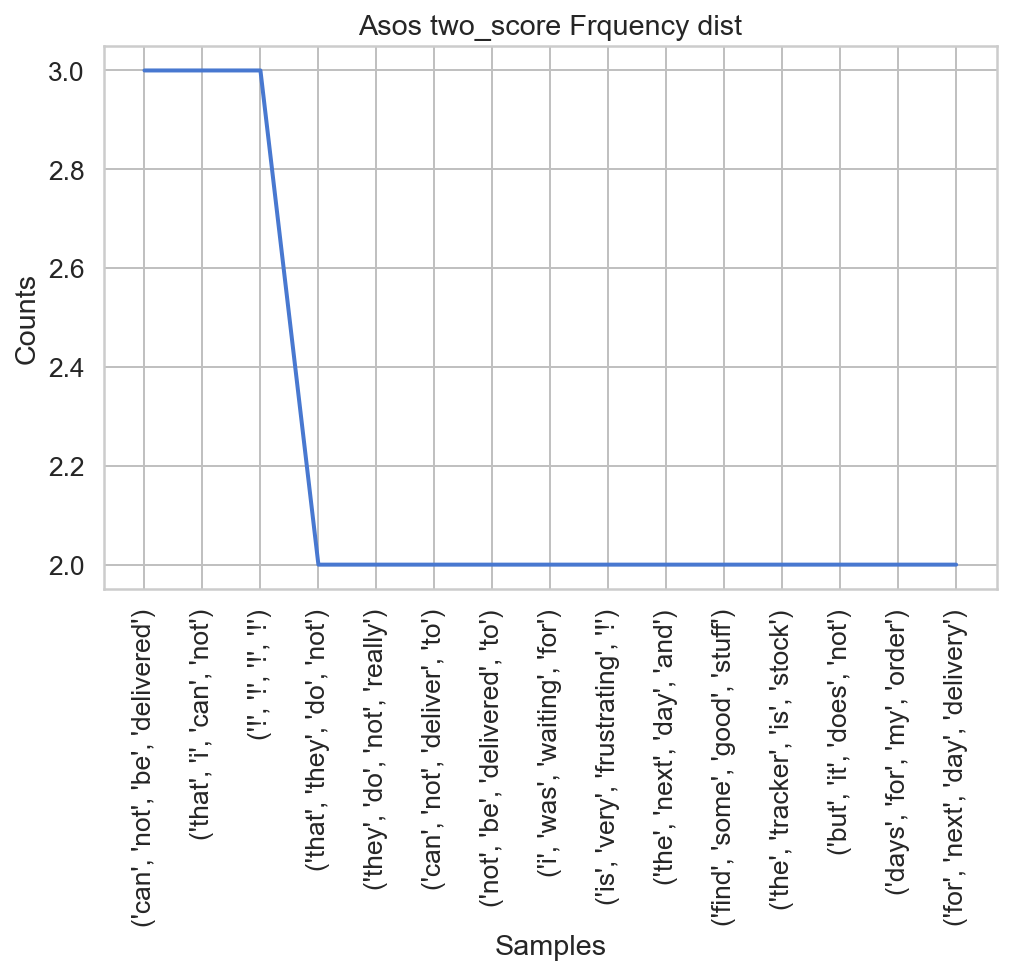

[(('items', 'in', 'my', 'bag'), 2), (('out', 'of', 'stock', 'and'), 2), (('and', 'i', 'really', 'like'), 2), (('always', 'out', 'of', 'stock'), 2), (('the', 'size', 'fit', 'tool'), 2), (('yous', 'already', 'had', 'it'), 2), (('!', '!', '!', '!'), 2), (('awesome', 'customer', 'support', '.'), 1), (('customer', 'support', '.', 'support'), 1), (('support', '.', 'support', 'is'), 1), (('.', 'support', 'is', 'good'), 1), (('support', 'is', 'good', 'but'), 1), (('is', 'good', 'but', 'the'), 1), (('good', 'but', 'the', 'clothes'), 1), (('but', 'the', 'clothes', 'are'), 1)]


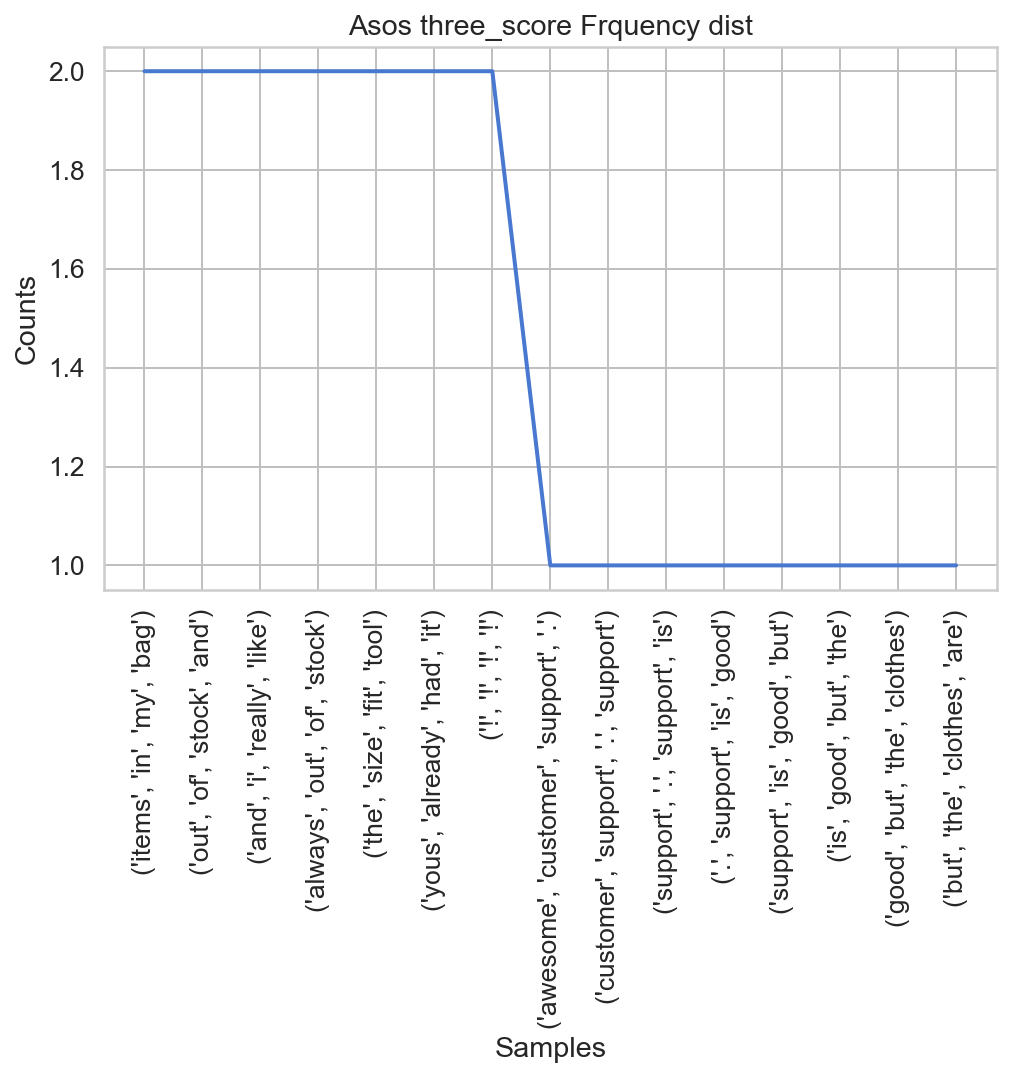

[(('easy', 'to', 'use', 'and'), 4), (('can', 'not', 'find', 'it'), 2), (('app', ',', 'easy', 'to'), 2), (('to', 'use', ',', 'great'), 2), ((',', 'the', 'app', 'is'), 2), (('easy', 'to', 'use', ','), 2), (('you', 'are', 'size', 'is'), 2), (('there', 'are', 'so', 'many'), 2), (('of', 'the', 'items', 'that'), 2), ((',', 'easy', 'to', 'use'), 2), (('i', 'have', 'is', 'when'), 2), (('have', 'is', 'when', 'ordering'), 2), (('get', 'next', 'day', 'delivery'), 2), (('next', 'day', 'delivery', 'i'), 2), (('item', 'out', 'of', 'stock'), 2)]


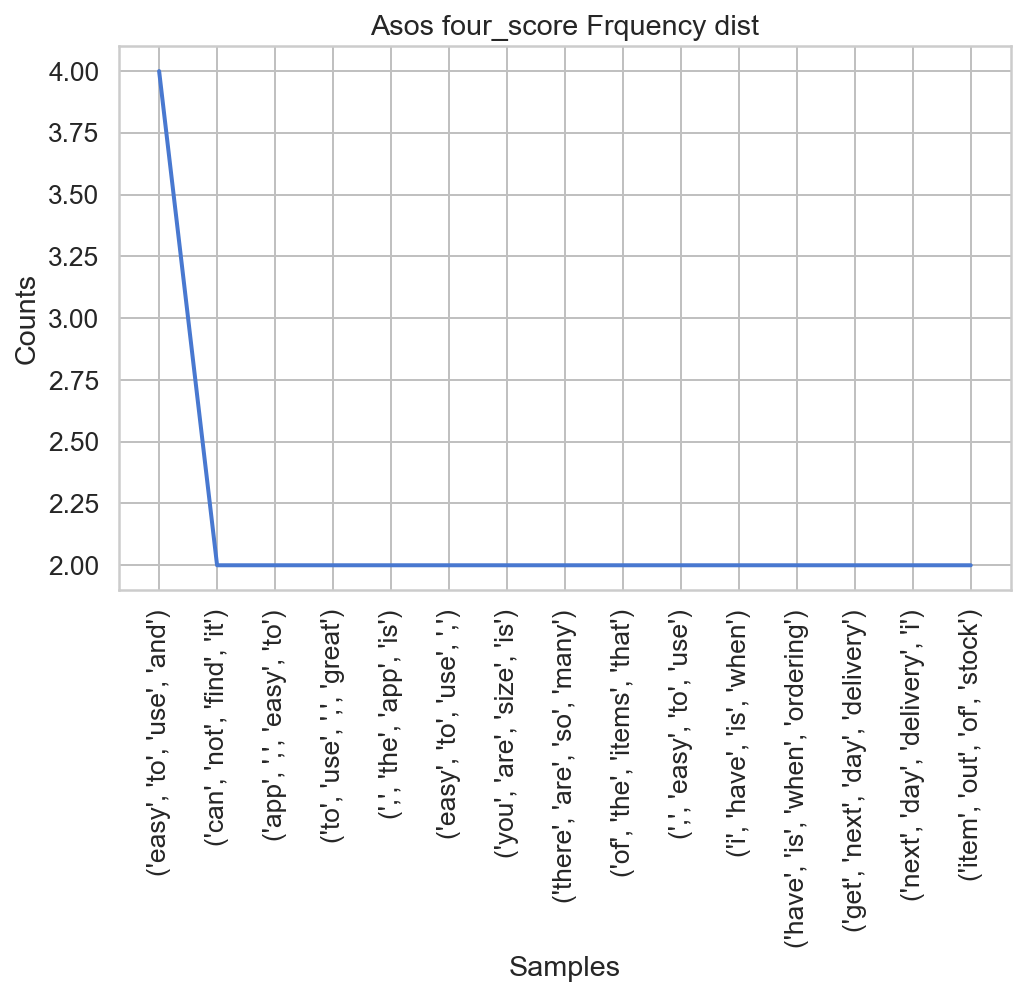

[(('easy', 'to', 'use', 'and'), 5), (('to', 'use', 'and', 'great'), 3), (('.', 'i', 'have', 'never'), 2), (('i', 'have', 'never', 'had'), 2), (('to', 'use', 'and', 'good'), 2), (('quick', 'and', 'easy', 'to'), 2), (('app', 'so', 'easy', 'to'), 2), (('easy', 'to', 'order', 'and'), 2), (('easy', 'to', 'use', ','), 2), (('and', 'so', 'easy', 'to'), 2), (('so', 'easy', 'to', 'use'), 2), (('!', 'easy', 'to', 'use'), 2), (('to', 'use', 'app', ','), 2), (('se', 'pueden', 'encontrar', 'ofertas'), 1), (('pueden', 'encontrar', 'ofertas', 'buenísimas'), 1)]


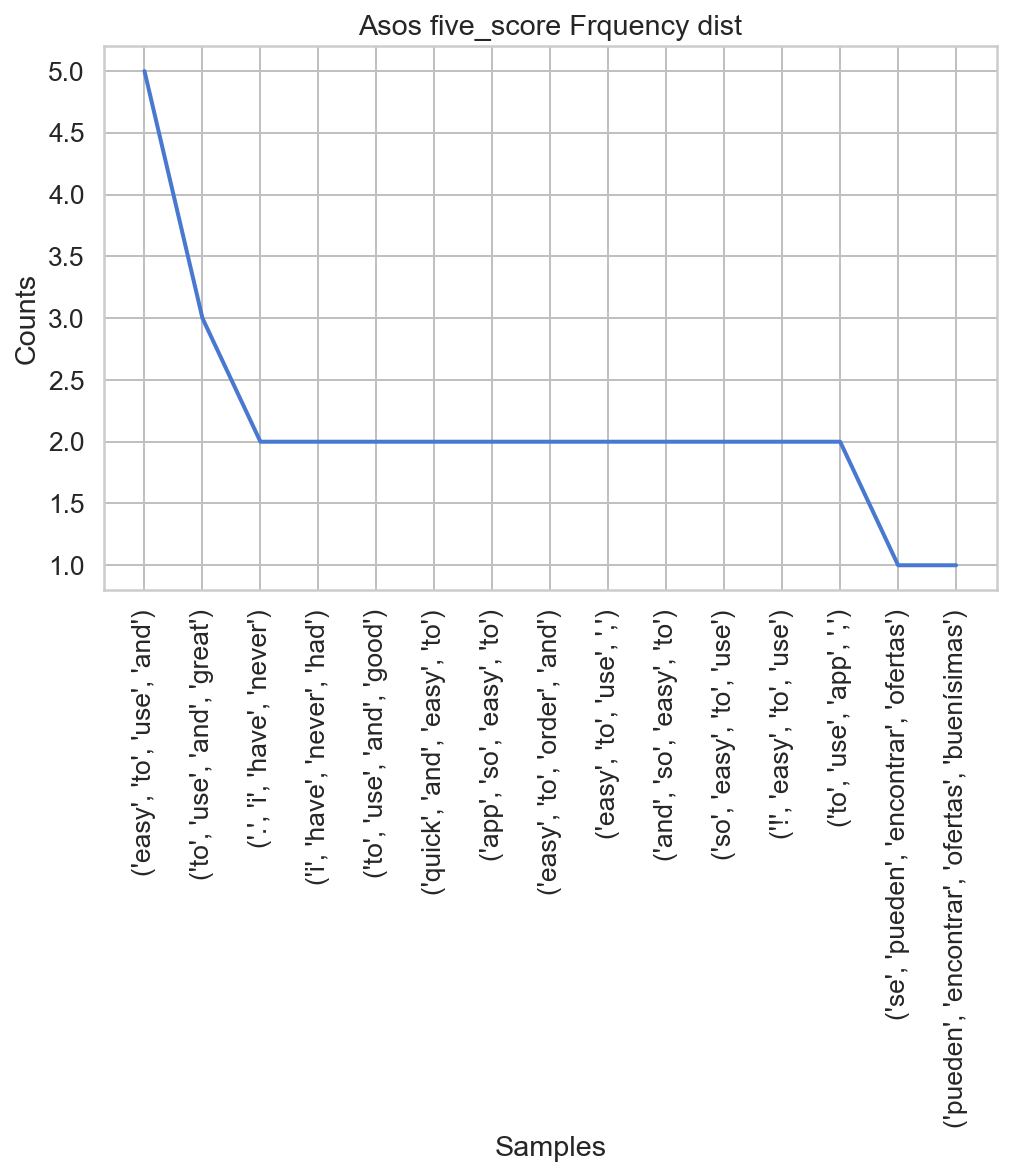

In [77]:
for score_level in asos_ngram_dict:
    score_level_fdist = FreqDist(asos_ngram_dict[score_level])
    print(score_level_fdist.most_common(15))
    plt.figure(figsize=(8, 5))
    score_level_fdist.plot(15,title='Asos ' + score_level + ' Frquency dist')


[(('!', '!', '!', '!'), 8), (('click', 'on', 'an', 'item'), 6), (('will', 'not', 'let', 'me'), 6), (('right', 'back', 'to', 'the'), 5), (('to', 'reset', 'my', 'password'), 5), (('back', 'to', 'the', 'start'), 4), (('you', 'right', 'back', 'to'), 4), (('back', 'to', 'the', 'top'), 4), (('oops', 'something', 'went', 'wrong'), 4), (('they', 'do', 'not', 'have'), 4), (('takes', 'me', 'to', 'the'), 4), (('to', 'the', 'home', 'page'), 4), (('can', 'not', 'log', 'in'), 4), (('i', 'can', 'not', 'even'), 4), (('then', 'go', 'back', 'to'), 3)]


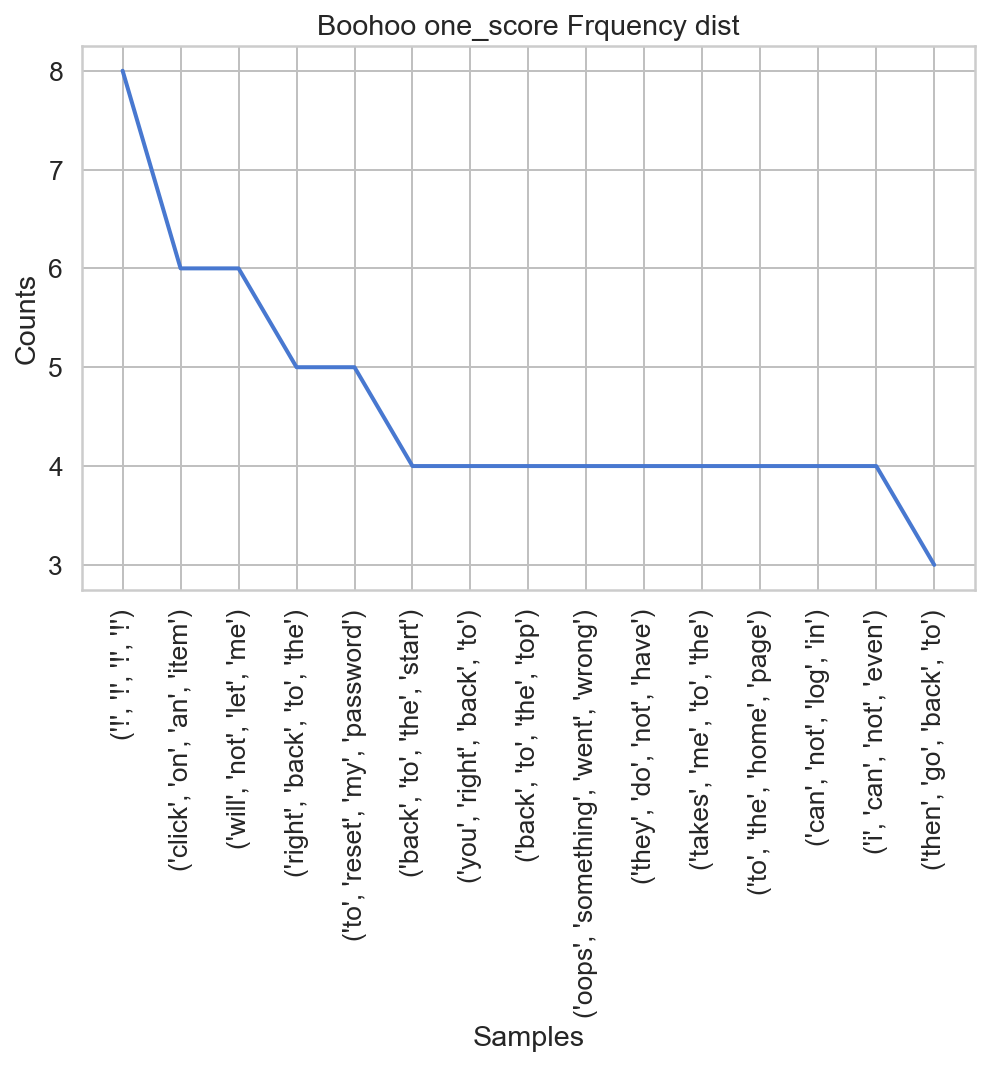

[(('back', 'to', 'the', 'top'), 6), (('to', 'the', 'top', 'of'), 6), (('the', 'top', 'of', 'the'), 6), (('will', 'not', 'let', 'me'), 6), (('to', 'love', 'this', 'app'), 4), (('can', 'not', 'see', 'all'), 4), (('but', 'the', 'app', 'is'), 4), (('top', 'of', 'the', 'page'), 4), (('and', 'i', 'can', 'not'), 4), (('you', 'click', 'on', 'an'), 3), (('click', 'on', 'an', 'item'), 3), (('back', 'to', 'where', 'you'), 3), (('right', 'back', 'to', 'the'), 3), (('to', 'where', 'you', 'left'), 3), (('where', 'you', 'left', 'off'), 3)]


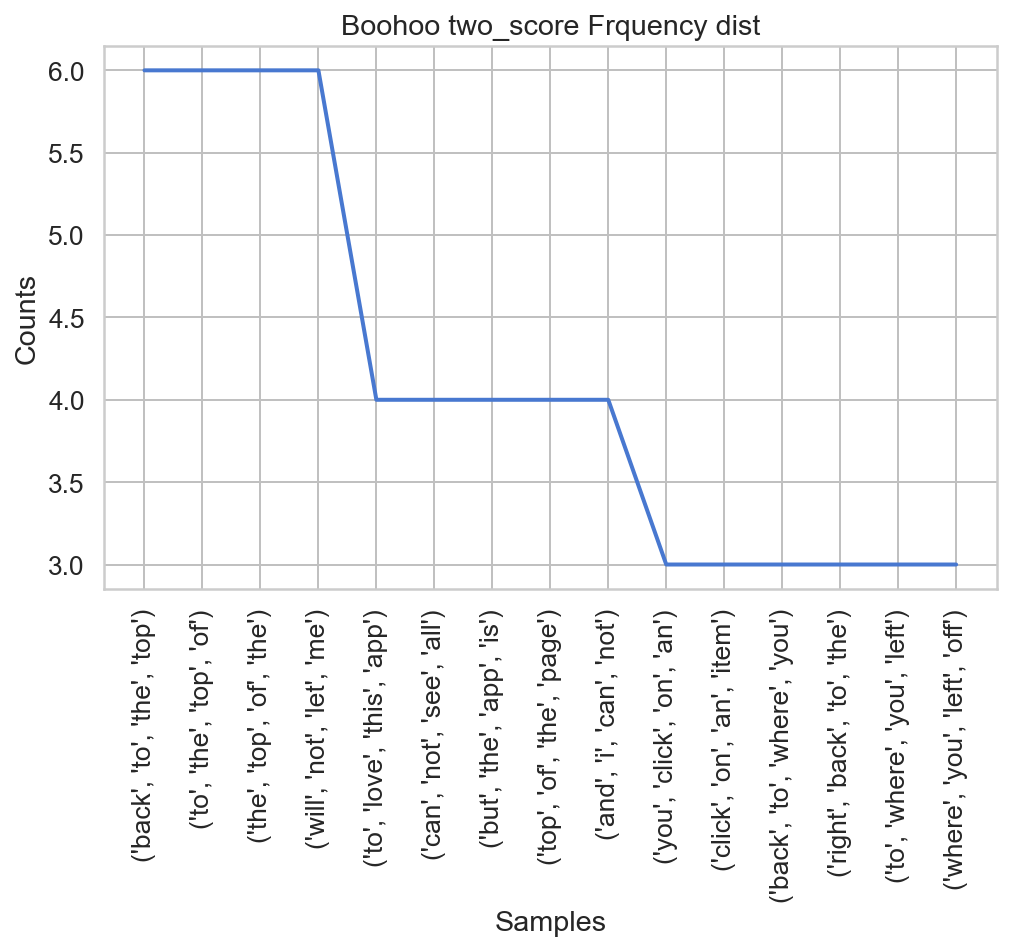

[(('the', 'top', 'of', 'the'), 5), (('takes', 'you', 'back', 'to'), 4), (('clothes', 'but', 'the', 'app'), 3), (('you', 'back', 'to', 'the'), 3), (('back', 'to', 'the', 'start'), 3), (('to', 'the', 'top', 'of'), 3), (('but', 'i', 'can', 'not'), 3), (('the', 'app', 'does', 'not'), 3), (('i', 'do', 'not', 'like'), 3), (('the', 'app', 'will', 'not'), 2), (('the', 'clothes', 'but', 'the'), 2), (('it', 'takes', 'you', 'back'), 2), (('top', 'of', 'the', 'page'), 2), (('i', 'did', 'not', 'have'), 2), (('right', 'back', 'to', 'the'), 2)]


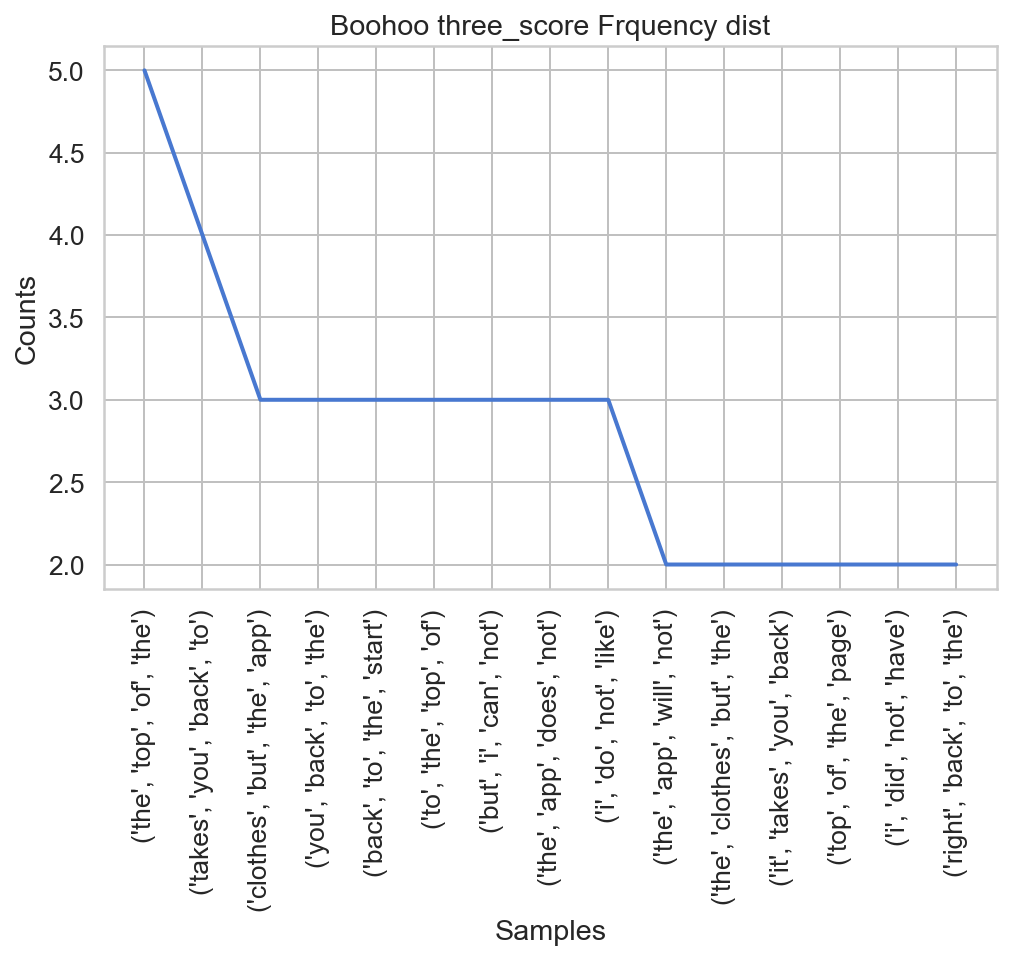

[(('the', 'only', 'thing', 'i'), 3), (('easy', 'to', 'use', ','), 3), (('the', 'app', 'is', 'that'), 2), (('love', 'boohoo', ',', 'but'), 2), (('you', 'have', 'to', 'start'), 2), (('you', 'could', 'review', 'items'), 2), (('app', 'is', 'good', 'but'), 2), (('the', 'height', 'of', 'the'), 2), (('height', 'of', 'the', 'model'), 2), (('.', 'other', 'than', 'that'), 2), (('.', 'so', 'far', 'i'), 2), (('only', 'thing', 'i', 'would'), 2), (('to', 'use', 'this', 'app'), 2), (('and', 'easy', 'to', 'use'), 2), (('easy', 'to', 'use', 'and'), 2)]


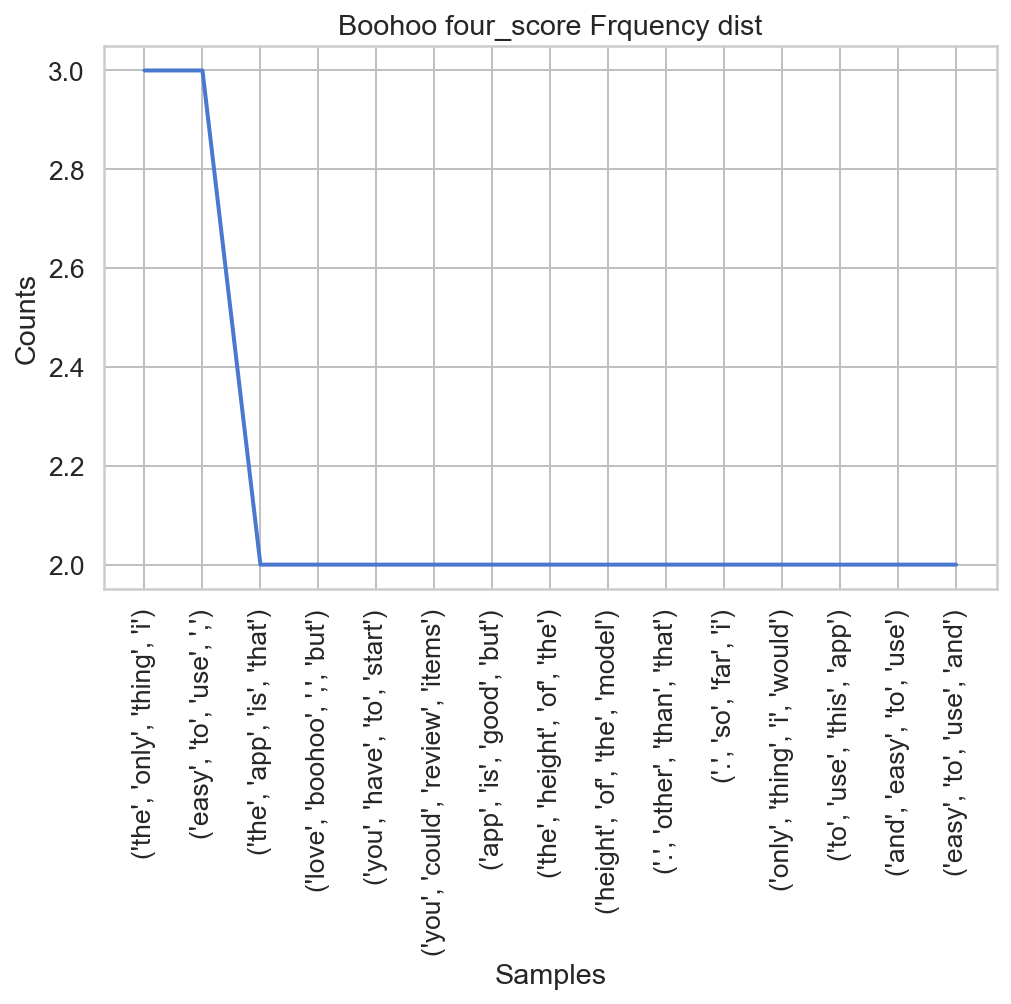

[(('!', '!', '!', '!'), 3), (('easy', 'to', 'use', 'and'), 3), (('!', 'love', 'it', '!'), 3), (('the', 'items', 'i', 'have'), 2), (('a', 'dress', 'and', 'it'), 2), (('great', 'value', 'for', 'money'), 2), (('quality', ',', 'i', 'love'), 2), (('easy', 'to', 'use', ','), 2), (('the', 'only', 'thing', 'is'), 2), (('*', '*', '*', '*'), 2), (('know', 'if', 'i', 'can'), 2), (('goodout', 'of', 'this', 'worldthey'), 1), (('of', 'this', 'worldthey', 'fixed'), 1), (('this', 'worldthey', 'fixed', 'the'), 1), (('worldthey', 'fixed', 'the', 'scrolling'), 1)]


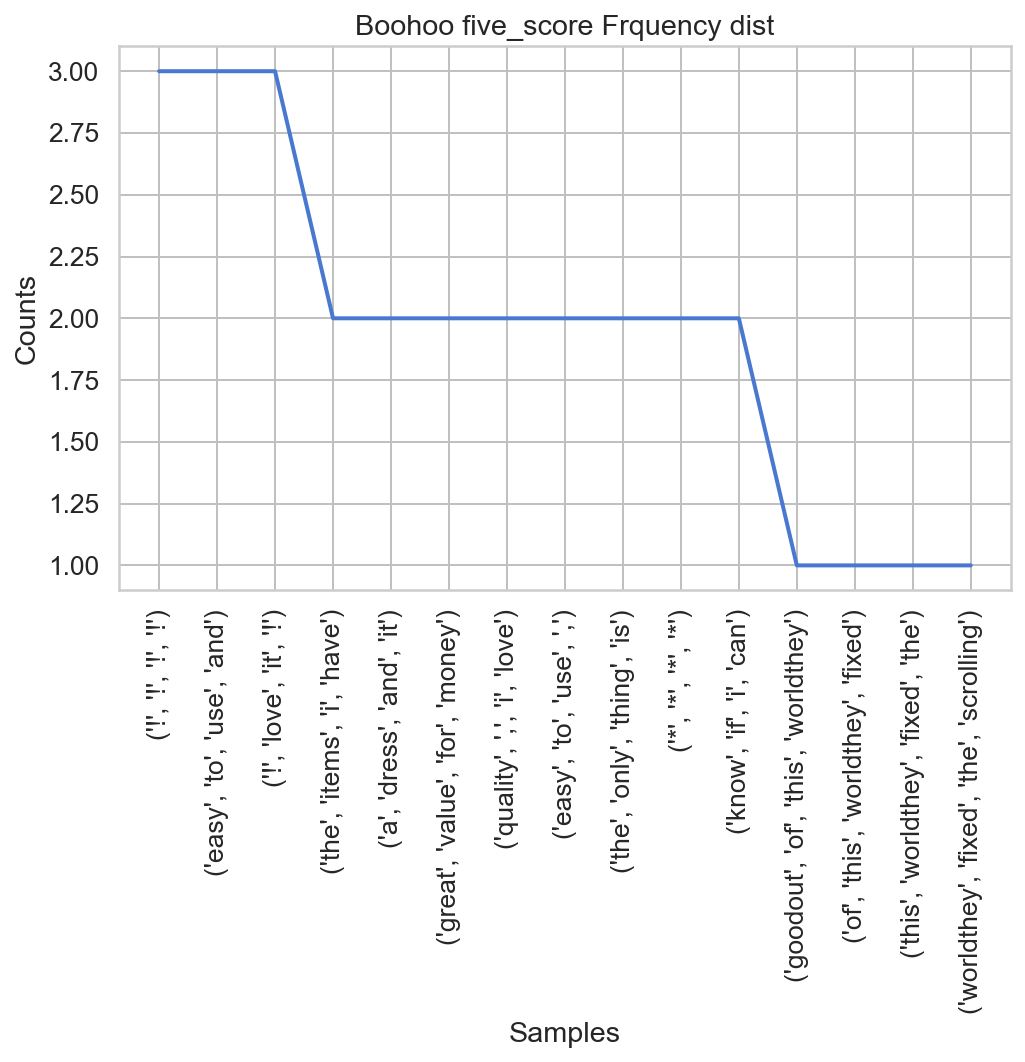

In [78]:
for score_level in boohoo_ngram_dict:
    score_level_fdist = FreqDist(boohoo_ngram_dict[score_level])
    print(score_level_fdist.most_common(15))
    plt.figure(figsize=(8, 5))
    score_level_fdist.plot(15,title='Boohoo ' + score_level + ' Frquency dist')

In [79]:
### Comparision: 15 most common ngrams. Asos vs. Boohoo for each star level

#need 15 most common grams at each score level for each company:
#Two libraries I need
#asos_ngram_dict
#boohoo_ngram_dict

def compare_ngrams(ngram1, ngram2, level):
    ngram1 = list(ngram1)
    ngram2 = list(ngram2)
    common=[]
    for gram in ngram1:
        if gram in ngram2:
            common.append(gram)
            
    if not common: # if not common means if the common list is empty,
        print(level,'The ngrams have no commonality') 
        # or you could print a message saying no commonality was found   


    return common 


In [80]:
#This loop creates a dictionary with the most common ngrams between the same 
#score levels of each company 

most_common_ngram_dict = {}
for score_level in asos_ngram_dict:
    score_level_fdist1 = FreqDist(asos_ngram_dict[score_level])
    score_level_fdist2 = FreqDist(boohoo_ngram_dict[score_level])
    most_common_ngram_dict[score_level] = compare_ngrams(score_level_fdist1.most_common(20), 
                                                         score_level_fdist2.most_common(20), score_level)
    #most_common_ngram_list.append(compare_ngrams(score_level_fdist1, score_level_fdist2))

one_score The ngrams have no commonality
three_score The ngrams have no commonality


In [81]:

#Get all the reviews seperated by score for each company. Reviews go from best to work (1 to 5) beggining
#at index 0

all_asos_reviews = []
for i in range(1,6):
    asos_score_content = [review
                      for review in app_reviews_dict_fixed['asos']
                      if review['score'] == i]
    all_asos_reviews.append(asos_score_content)

    
 
all_boohoo_reviews = []
for i in range(1,6):
    boohoo_score_content = [review
                      for review in app_reviews_dict_fixed['boohoo']
                      if review['score'] == i]
    all_boohoo_reviews.append(boohoo_score_content)


# all_asos_reviews_dict = {'one_score':all_asos_reviews[0], 'two_score':all_asos_reviews[1],
#                          'three_score':all_asos_reviews[2], 'four_score':all_asos_reviews[3],
#                          'five_score':all_asos_reviews[4]}


In [82]:
##This just takes the dictionaries asos_ngram_dict and boohoo_ngram_dict and makes them
#into lists

asos_list_ngrams = []
for score_level in asos_ngram_dict:
    asos_list_ngrams.append(asos_ngram_dict[score_level])
    
boohoo_list_ngrams = []
for score_level in boohoo_ngram_dict:
    boohoo_list_ngrams.append(boohoo_ngram_dict[score_level])

In [83]:
#These makes a list for each companies most common ngrams. The list indexes are by score level 1 to 5

asos_list_mostFreqngrams = []
for grams in asos_list_ngrams:
    grams_fdist1 = FreqDist(grams)
    asos_list_mostFreqngrams.append(grams_fdist1.most_common(20))
    
boohoo_list_mostFreqngrams = []
for grams in boohoo_list_ngrams:
    grams_fdist1 = FreqDist(grams)
    boohoo_list_mostFreqngrams.append(grams_fdist1.most_common(20))   

In [84]:
#This is just a cleaner version of the list asos_list_mostFreqngrams, boohoo_list_mostFreqngrams
#except that is just one list with 100 items instead of 5 sublists with 20 items each
asos_list_mostFreqngrams_cleaned = []
for score_level in asos_list_mostFreqngrams:
    #append_list = []
    for gram in score_level:
        needed = gram[0]
        #append_list.append(list(needed))
        asos_list_mostFreqngrams_cleaned.append(list(needed))


boohoo_list_mostFreqngrams_cleaned = []
for score_level in boohoo_list_mostFreqngrams:
    #append_list = []
    for gram in score_level:
        needed = gram[0]
        #append_list.append(list(needed))
        boohoo_list_mostFreqngrams_cleaned.append(list(needed))

In [85]:
#These are lists of only the review content . These were made to make the comparison process of
#ngrams and the review content easier
all_asos_content = []
for index in all_asos_reviews:
    all_asos_content.append([content['content']
                            for content in index])
all_boohoo_content = []
for index in all_boohoo_reviews:
    all_boohoo_content.append([content['content']
                            for content in index])

In [86]:
#Now these lists finally have the ngrams listed as string. This will make is possible to compare. 

asos_ngram_strings = []
for ngram in asos_list_mostFreqngrams_cleaned:
    text = ''
    for element in ngram:
        text = text + ' ' + element
    asos_ngram_strings.append(text)
    #print(text)
    
boohoo_ngram_strings = []
for ngram in boohoo_list_mostFreqngrams_cleaned:
    text = ''
    for element in ngram:
        text = text + ' ' + element
    boohoo_ngram_strings.append(text)
    #print(text)

In [87]:
#asos_ngram_strings ->list with 100 elements
#boohoo_ngram_strings -> list with 100 elements

#all_asos_content -> all asos review content
#all_boohoo_content -> all boohoo review content

  

In [88]:
#This goes through all the comments and makes a list with only the comments
#that have the most common ngrams. The list has 5 elements, each of which are lists
#with the review content

asos_reviews_with_ngrams = []
for level in all_asos_content:
    level_list = []
    for content in level:
        for ngram in asos_ngram_strings:
            if ngram in content:
                #print('yes')
                level_list.append(content)
    asos_reviews_with_ngrams.append(level_list)
    
boohoo_reviews_with_ngrams = []
for level in all_boohoo_content:
    level_list = []
    for content in level:
        for ngram in boohoo_ngram_strings:
            if ngram in content:
                #print('yes')
                level_list.append(content)
    boohoo_reviews_with_ngrams.append(level_list)
    
    
###Ensuring the reviews are unique just in case above code produced duplicates. 
asos_reviews_with_ngrams_clean = [list(set(level))
                                 for level in asos_reviews_with_ngrams]
boohoo_reviews_with_ngrams_clean = [list(set(level))
                                 for level in boohoo_reviews_with_ngrams]

##These are all the reviews that contain the most frequent ngrams we found. The list has five elements
#each containing a list of reviews. The indexes represent the score levels from 1 to 5. 

In [89]:
len(boohoo_reviews_with_ngrams_clean[0])

52

In [90]:
#Use this loop to see common themes at each score level

for i in boohoo_reviews_with_ngrams_clean[1]:
    print('')
    print(i)


Boohoo clothing can be hit and miss but the app is terrible. Cant search similar items and the wishlist is all over the place, even when I order them by recently added it doesnt change the layout so with all the things in my wishlist I cant find a particular item because it wont sort them correctly. Search option isnt working properly either. Says there is 500+ items but only shows me a few

the app is okay but after you have clicked on an item and try return to the menu you have to start from the top and scroll all the way down until you find where you last were looking!!

When you click on an item to have a better look, the app takes you back to the top. Freezes a lot! Trying to delete out of stock items from wish list is impossible

Love boohoo but I can not log into this app. Keeps telling me is store and I can not change it to UK. Not sure why as when I get the same app on my iPhone it works perfect and I can log in.

Not sure what the point of this app is right now. Ca not view 

In [91]:
#Exploring sentiment analysis. Eventually found the average score level for what classified as 
#'positive' and 'negative' reviews by sentiment analysis

In [92]:
import os
import nltk
from os import listdir
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [93]:
sid = SIA()

In [94]:
def find_Vader_review_score(review):
    
    
    #Do not stem or lemmatize when using vader
    
    sentiment = sid.polarity_scores(review) 
    if sentiment['compound'] < 0:
        score = review,'Review is overall negative', sentiment, sentiment['compound']
    elif sentiment == 0:
        score = review,'Review is overall neutral',sentiment
    else:
        score = review,'Review is overall positive', sentiment, sentiment['compound']
    
    
    return list(score)

In [95]:
#### Going to add up all the 'positive', negative and neurtral scores vader provides for each company

# ASOS 
def count_score_type(dictionary, company):
    
    pos_review = []
    for review in dictionary[company]:  #going through each review
        score = find_Vader_review_score(review['content'])  #calling vader function to find sentinment score
        if 'positive' in score[1]: 
            pos_review.append(review) #appending to list if score is considered 'positive'
    
    neu_review = []
    for review in dictionary[company]:  #going through each review
        score = find_Vader_review_score(review['content'])  #calling vader function to find sentinment score
        if 'neutral' in score[1]: 
            neu_review.append(review) #appending to list if score is considered 'neutral'
    
    neg_review = []
    for review in dictionary[company]:  #going through each review
        score = find_Vader_review_score(review['content'])  #calling vader function to find sentinment score
        if 'negative' in score[1]: 
            neg_review.append(review) #appending to list if score is considered 'neutral'
       
    
    
    return pos_review, neu_review, neg_review

In [96]:
asos_pos_reviews, asos_neu_reviews, asos_neg_reviews = count_score_type(app_reviews_dict_fixed, 'asos')
print('pos:',len(asos_pos_reviews), 'neu', len(asos_neu_reviews), 'neg', len(asos_neg_reviews))

boohoo_pos_reviews, boohoo_neu_reviews, boohoo_neg_reviews = count_score_type(app_reviews_dict_fixed, 'boohoo')
print('pos:',len(boohoo_pos_reviews), 'neu', len(boohoo_neu_reviews), 'neg', len(boohoo_neg_reviews))

pos: 692 neu 0 neg 258
pos: 663 neu 0 neg 287


In [97]:
####  Lets look at the average SCORE score for what Vader calls positive or negative ###

asos_vader_dict = {'pos':asos_pos_reviews, 'neu': asos_neu_reviews, 'neg': asos_neg_reviews}
boohoo_vader_dict = {'pos':boohoo_pos_reviews, 'neu': boohoo_neu_reviews, 'neg': boohoo_neg_reviews}

def vader_score_AVG(dictionary):
    
    pos_score_list = [review['score']
                     for review in dictionary['pos']]
    
    neg_score_list = [review['score']
                     for review in dictionary['neg']]   

    dictionary['pos_score'] = pos_score_list
    dictionary['neg_score'] = neg_score_list
    
    return dictionary


In [98]:
import statistics
from statistics import mean, median, mode

In [99]:
#Dictionaries with the addition of all positive and negative 'scores.'
#This wil make it easier to find averages
asos_vader_score_dict = vader_score_AVG(asos_vader_dict)
boohoo_vader_score_dict = vader_score_AVG(boohoo_vader_dict)

In [100]:
#Function to find quick statistics

def quick_stats(dictionary):
    quick_stats = { 'mean pos':mean(dictionary['pos_score']), 'median pos':median(dictionary['pos_score']), 
                  'mode pos':mode(dictionary['pos_score']), 'min pos':min(dictionary['pos_score']), 
                  'max pos':max(dictionary['pos_score']),
                   'mean neg':mean(dictionary['neg_score']), 'median neg':median(dictionary['neg_score']), 
                  'mode neg': mode(dictionary['neg_score']), 'min neg':min(dictionary['neg_score']), 
                  'max neg':max(dictionary['neg_score'])
                  }
    
    return quick_stats

In [101]:
asos_quickStats = quick_stats(asos_vader_score_dict)
boohoo_quickStats = quick_stats(boohoo_vader_score_dict)
print(asos_quickStats)
print(boohoo_quickStats)

{'mean pos': 3.4523121387283235, 'median pos': 4.0, 'mode pos': 5, 'min pos': 1, 'max pos': 5, 'mean neg': 1.7868217054263567, 'median neg': 2.0, 'mode neg': 1, 'min neg': 1, 'max neg': 5}
{'mean pos': 3.475113122171946, 'median pos': 4, 'mode pos': 5, 'min pos': 1, 'max pos': 5, 'mean neg': 1.9024390243902438, 'median neg': 2, 'mode neg': 1, 'min neg': 1, 'max neg': 5}
